In [5]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

from boruta import BorutaPy

#Optimization
import optuna

#Experiment tracking
import mlflow

In [6]:
train_path = os.path.join('data', 'train.csv')
train_extra_path = os.path.join('data', 'train_extra.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
train_extra = pd.read_csv(train_extra_path)
train_extra['rainfall'] = train_extra['rainfall'].map({'yes': 1, 'no': 0})
ord_cols = raw_train_data.columns
train_extra.columns = train_extra.columns.str.strip()
train_extra = train_extra[ord_cols]

raw_train_data = pd.concat([raw_train_data, train_extra], ignore_index=True)
raw_train_data.dropna(inplace= True)

raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)

raw_train_data.drop_duplicates(inplace= True)

In [7]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2555 non-null   int64  
 1   pressure       2555 non-null   float64
 2   maxtemp        2555 non-null   float64
 3   temparature    2555 non-null   float64
 4   mintemp        2555 non-null   float64
 5   dewpoint       2555 non-null   float64
 6   humidity       2555 non-null   float64
 7   cloud          2555 non-null   float64
 8   sunshine       2555 non-null   float64
 9   winddirection  2555 non-null   float64
 10  windspeed      2555 non-null   float64
 11  rainfall       2555 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 259.5 KB


In [8]:
print(raw_train_data.shape)
raw_train_data.head()

(2555, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


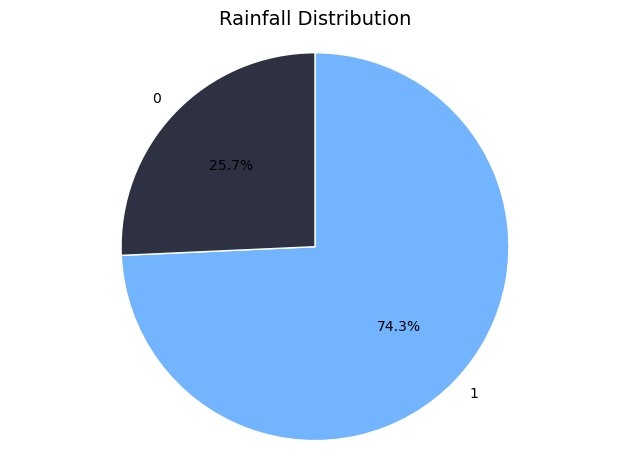

In [9]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
raw_train_data.skew()

day              0.211569
pressure         0.295777
maxtemp         -0.498073
temparature     -0.572202
mintemp         -0.665021
dewpoint        -1.017435
humidity        -0.745531
cloud           -1.314520
sunshine         0.600403
winddirection    0.721490
windspeed        0.769942
rainfall        -1.111978
dtype: float64

In [12]:
def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.fit_transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)

    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

def test_data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)
    
    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

In [13]:
X_train = raw_train_data.drop(columns= 'rainfall')
y_train = raw_train_data['rainfall']
X_train = data_preproccesing(X_train) 

In [14]:
X_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,...,sunshine_cat,windspeed_cat,temp_change_cat,temp_ratio_cat,wind_dir_rad_cat,wind_direction_sin_cat,wind_direction_cos_cat,avg_temp_cat,dewpoint_depression_cat,sunshine_ratio_cat
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,4.488636,1.1,17.2,...,1.1,17.2,1.3000000000000007,1.065326633165829,1.0471975511965976,0.8660254037844386,0.5000000000000001,20.549999999999997,1.2000000000000028,0.012359550561797755
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,4.521789,0.0,21.9,...,0.0,21.9,0.3999999999999986,1.0253164556962024,0.8726646259971648,0.766044443118978,0.6427876096865394,16.0,1.4999999999999982,0.0
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,3.871201,8.3,18.1,...,8.3,18.1,4.799999999999999,1.3287671232876712,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.0,6.800000000000001,0.1729166666666667
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,4.564348,0.0,35.6,...,0.0,35.6,1.2000000000000028,1.0710059171597635,1.0471975511965976,0.8660254037844386,0.5000000000000001,17.5,1.0,0.0
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,3.828641,3.6,24.8,...,3.6,24.8,6.100000000000001,1.4013157894736843,0.6981317007977318,0.6427876096865393,0.766044443118978,18.25,8.799999999999999,0.0782608695652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,27,1022.7,18.8,17.7,16.9,15.0,84.0,4.510860,0.0,18.4,...,0.0,18.4,1.9000000000000021,1.1124260355029587,0.5235987755982988,0.49999999999999994,0.8660254037844387,17.85,2.6999999999999993,0.0
2552,28,1026.6,18.6,17.3,16.3,12.8,75.0,4.454347,1.0,25.9,...,1.0,25.9,2.3000000000000007,1.1411042944785277,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.450000000000003,4.5,0.011627906976744186
2553,29,1025.9,18.9,17.7,16.4,13.3,75.0,4.369448,4.6,33.4,...,4.6,33.4,2.5,1.1524390243902438,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.65,4.399999999999999,0.05822784810126582
2554,30,1025.3,19.2,17.3,15.2,13.3,78.0,4.465908,1.2,20.9,...,1.2,20.9,4.0,1.263157894736842,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.2,4.0,0.013793103448275862


In [56]:

def objective(trial, X, y):
    # Definición de hiperparámetros para LightGBM
    params = {
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 25, 125),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0001, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'random_state': 42,
        'verbosity': -1
    }
    # Creación del clasificador LightGBM con los parámetros sugeridos
    clf = LGBMClassifier(**params)
    
    # Utilizamos StratifiedKFold para mantener el balance de clases (5 particiones)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    
    with mlflow.start_run():
        for fold, (train_idx, val_idx) in enumerate(skf.split(X,y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

In [57]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-09 20:49:42,559] A new study created in memory with name: no-name-bb5d5504-d71a-425c-92b7-d79d2b704427
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Trial 0 - Train AUC: 0.9397 | Validation AUC: 0.8943


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 1 - Train AUC: 0.9580 | Validation AUC: 0.8903


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 2 - Train AUC: 0.9837 | Validation AUC: 0.8951


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 3 - Train AUC: 0.9841 | Validation AUC: 0.8832


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 4 - Train AUC: 0.9055 | Validation AUC: 0.8882


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 5 - Train AUC: 0.9308 | Validation AUC: 0.8903


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 6 - Train AUC: 0.9002 | Validation AUC: 0.8777


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 7 - Train AUC: 0.9234 | Validation AUC: 0.8865


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 8 - Train AUC: 0.9152 | Validation AUC: 0.8923


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 9 - Train AUC: 0.8971 | Validation AUC: 0.8822


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 10 - Train AUC: 0.9693 | Validation AUC: 0.8865


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 11 - Train AUC: 0.9487 | Validation AUC: 0.8946


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 12 - Train AUC: 0.9416 | Validation AUC: 0.8920


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 13 - Train AUC: 0.9543 | Validation AUC: 0.8919


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 14 - Train AUC: 0.9581 | Validation AUC: 0.8954


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 15 - Train AUC: 0.9377 | Validation AUC: 0.8929


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 16 - Train AUC: 0.9264 | Validation AUC: 0.8935


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 17 - Train AUC: 0.9593 | Validation AUC: 0.8937


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 18 - Train AUC: 0.9724 | Validation AUC: 0.8936
Trial 19 - Train AUC: 0.8989 | Validation AUC: 0.8852


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 20 - Train AUC: 0.9260 | Validation AUC: 0.8904


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 21 - Train AUC: 0.9344 | Validation AUC: 0.8929


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 22 - Train AUC: 0.9332 | Validation AUC: 0.8928


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 23 - Train AUC: 0.9873 | Validation AUC: 0.8865


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 24 - Train AUC: 0.9357 | Validation AUC: 0.8934


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 25 - Train AUC: 0.9297 | Validation AUC: 0.8915


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 26 - Train AUC: 0.9337 | Validation AUC: 0.8924


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 27 - Train AUC: 0.9648 | Validation AUC: 0.8956


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 28 - Train AUC: 0.9181 | Validation AUC: 0.8817


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 29 - Train AUC: 0.9307 | Validation AUC: 0.8935


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 30 - Train AUC: 0.9187 | Validation AUC: 0.8907


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 31 - Train AUC: 0.9754 | Validation AUC: 0.8951


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 32 - Train AUC: 0.9802 | Validation AUC: 0.8936


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 33 - Train AUC: 0.9941 | Validation AUC: 0.8911


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 34 - Train AUC: 0.9684 | Validation AUC: 0.8948


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 35 - Train AUC: 0.9409 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 36 - Train AUC: 0.9835 | Validation AUC: 0.8794


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 37 - Train AUC: 0.9363 | Validation AUC: 0.8936


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 38 - Train AUC: 0.9365 | Validation AUC: 0.8961


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 39 - Train AUC: 0.9293 | Validation AUC: 0.8934


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 40 - Train AUC: 0.9318 | Validation AUC: 0.8942


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 41 - Train AUC: 0.9257 | Validation AUC: 0.8941


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 42 - Train AUC: 0.9414 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 43 - Train AUC: 0.9490 | Validation AUC: 0.8939


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 44 - Train AUC: 0.9988 | Validation AUC: 0.8817


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 45 - Train AUC: 0.9265 | Validation AUC: 0.8920


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 46 - Train AUC: 0.9717 | Validation AUC: 0.8958


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 47 - Train AUC: 0.9763 | Validation AUC: 0.8954


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 48 - Train AUC: 0.9321 | Validation AUC: 0.8944


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 49 - Train AUC: 0.9535 | Validation AUC: 0.8949


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 50 - Train AUC: 0.9093 | Validation AUC: 0.8897


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 51 - Train AUC: 0.9772 | Validation AUC: 0.8941


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 52 - Train AUC: 0.9645 | Validation AUC: 0.8911


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 53 - Train AUC: 0.9770 | Validation AUC: 0.8926


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 54 - Train AUC: 0.9731 | Validation AUC: 0.8939


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 55 - Train AUC: 0.9993 | Validation AUC: 0.8821


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 56 - Train AUC: 0.9441 | Validation AUC: 0.8966


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 57 - Train AUC: 0.9404 | Validation AUC: 0.8951


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 58 - Train AUC: 0.9558 | Validation AUC: 0.8948


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 59 - Train AUC: 0.9463 | Validation AUC: 0.8952


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 60 - Train AUC: 0.9222 | Validation AUC: 0.8928


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 61 - Train AUC: 0.9460 | Validation AUC: 0.8946


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 62 - Train AUC: 0.9222 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 63 - Train AUC: 0.9588 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 64 - Train AUC: 0.9495 | Validation AUC: 0.8933


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 65 - Train AUC: 0.9353 | Validation AUC: 0.8943


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 66 - Train AUC: 0.9572 | Validation AUC: 0.8940


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 67 - Train AUC: 0.9277 | Validation AUC: 0.8919


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 68 - Train AUC: 0.9376 | Validation AUC: 0.8947


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 69 - Train AUC: 0.9256 | Validation AUC: 0.8921


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 70 - Train AUC: 0.9786 | Validation AUC: 0.8888


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 71 - Train AUC: 0.9838 | Validation AUC: 0.8933


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 72 - Train AUC: 0.9454 | Validation AUC: 0.8960


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 73 - Train AUC: 0.9448 | Validation AUC: 0.8949


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 74 - Train AUC: 0.9369 | Validation AUC: 0.8955


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 75 - Train AUC: 0.9440 | Validation AUC: 0.8960


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 76 - Train AUC: 0.9380 | Validation AUC: 0.8948


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 77 - Train AUC: 0.9345 | Validation AUC: 0.8954


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 78 - Train AUC: 0.9363 | Validation AUC: 0.8950


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 79 - Train AUC: 0.9383 | Validation AUC: 0.8956


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 80 - Train AUC: 0.9297 | Validation AUC: 0.8940


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 81 - Train AUC: 0.9284 | Validation AUC: 0.8937


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 82 - Train AUC: 0.9391 | Validation AUC: 0.8945


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 83 - Train AUC: 0.9004 | Validation AUC: 0.8874


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 84 - Train AUC: 0.9482 | Validation AUC: 0.8956


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 85 - Train AUC: 0.9489 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 86 - Train AUC: 0.9569 | Validation AUC: 0.8937


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 87 - Train AUC: 0.9708 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 88 - Train AUC: 0.9294 | Validation AUC: 0.8936


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 89 - Train AUC: 0.9501 | Validation AUC: 0.8938


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 90 - Train AUC: 0.9469 | Validation AUC: 0.8919


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 91 - Train AUC: 0.9361 | Validation AUC: 0.8947


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 92 - Train AUC: 0.9215 | Validation AUC: 0.8900


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 93 - Train AUC: 0.9127 | Validation AUC: 0.8905


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 94 - Train AUC: 0.9629 | Validation AUC: 0.8940


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 95 - Train AUC: 0.9414 | Validation AUC: 0.8944


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 96 - Train AUC: 0.9158 | Validation AUC: 0.8897


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 97 - Train AUC: 0.9328 | Validation AUC: 0.8926


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 98 - Train AUC: 0.9751 | Validation AUC: 0.8935


/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/ws/5628jcln1q1g_nmpns07dt_m0000gn/T/ipykernel_14057/3176874039.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

Trial 99 - Train AUC: 0.9685 | Validation AUC: 0.8933


In [58]:
best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.023316433186024717, 'num_leaves': 286, 'max_depth': 9, 'min_child_samples': 45, 'min_child_weight': 1.0590121263232959, 'subsample': 0.7159049715410939, 'colsample_bytree': 0.5021222945566725, 'reg_alpha': 0.00016198477000848877, 'reg_lambda': 0.00026397983758290404, 'n_estimators': 78, 'min_split_gain': 0.2569406065607691, 'subsample_freq': 1, 'max_bin': 112, 'scale_pos_weight': 1.689328839727197}
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 1899, number of negative: 657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4456
[LightGBM] [Info] Number of data points in the train set: 2556, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742958 -> initscore=1.061399
[LightGBM] [Info] Start training from score 1.061399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMClassifier(colsample_bytree=0.5021222945566725,
               learning_rate=0.023316433186024717, max_bin=112, max_depth=9,
               min_child_samples=45, min_child_weight=1.0590121263232959,
               min_split_gain=0.2569406065607691, n_estimators=78,
               num_leaves=286, reg_alpha=0.00016198477000848877,
               reg_lambda=0.00026397983758290404,
               scale_pos_weight=1.689328839727197, subsample=0.7159049715410939,
               subsample_freq=1)

In [59]:
X_test = test_data_preproccesing(raw_test_data)

In [60]:
predictions = best_model.predict_proba(X_test)[:, 1]

In [61]:
sample_submission['rainfall'] = predictions

In [62]:
sample_submission.to_csv('submission.csv', index= False)

In [79]:
import threading
counter = 0
def increment():
    global counter
    for _ in range(1000000):
     counter += 1
t1 = threading.Thread(target=increment)
t2 = threading.Thread(target=increment)
t1.start()
t2.start()
t1.join()
t2.join()
print(counter)

2000000
